In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import os
from matplotlib import pyplot as plt

import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import log_loss
from decentralized_SGD_logistic import DecentralizedSGDLogistic
from sklearn.linear_model import SGDClassifier
from scipy.special import expit as sigmoid

from helpers import plot_losses

## RCV dataset from ChocoSGD Paper

In [13]:
def run_logistic(A, y, param,):
    m = DecentralizedSGDLogistic(param)
    res = m.fit(A, y)
    print('{} - score: {1:.4f}'.format(param, m.score(A, y)))
    return res, m

### Load dataset

In [3]:
dataset_path = os.path.expanduser('../ChocoSGD/data/rcv1_test.binary.bz2')
print('Loading dataset...')
A, y = load_svmlight_file(dataset_path)
A_p = A[:100000]
y_p = y[:100000]
y_p = 1*(y_p > 0)

Loading dataset...


### Compute the baseline with SGD

In [5]:
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A_p.shape[0])
clf.fit(A_p, y_p)
print(clf.score(A_p, y_p))
x_predict = clf.predict(A_p)
exact_optimum = log_loss(x_predict, y_p) + (1 / A_p.shape[0]) * np.sum(x_predict**2)

/home/adirlou/.local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


0.97885


### Compute with Decentralized SGD

In [ ]:
reg = 1 / A_p.shape[0]
n_features = A_p.shape[1]

params_disconnected = Parameters(num_epoch=5, lr_type='bottou',
                           initial_lr=10, tau=n_features, regularizer=reg,
                           quantization='full', n_machines=128,
                           method='plain',topology='complete', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive')

res_disconnected, dec_log = run_logistic(A_p, y_p, params_disconnected)

"""params_ring = dict(name="chocosgd-centralized", num_epoch=5, lr_type='bottou',
                           initial_lr=0.2, tau=n_features, regularizer=reg,
                           quantization='full', n_cores=10,
                           method='plain', topology='centralized', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive')

res_centralized = run_logistic(A_p, y_p, params_ring)"""


## Higgs Boson Dataset

In [4]:
def run_logistic(A, y, param, logging=False):
    m = DecentralizedSGDLogistic(**param)
    list_losses = m.fit(A, y, logging=logging)
    if logging:
        print()
        print('{0} - score: {1:.4f}'.format(param, m.score(A, y)))
    return list_losses

In [5]:
def load_csv_data(data_path):
    """Loads data and returns y (class labels), tX (features) and ids (event ids)"""
    y = np.genfromtxt(data_path, delimiter=",", skip_header=1, dtype=str, usecols=1)
    x = np.genfromtxt(data_path, delimiter=",", skip_header=1)
    input_data = x[:, 2:]

    # convert class labels from strings to binary (-1,1)
    yb = np.ones(len(y))
    yb[np.where(y=='b')] = -1

    return yb, input_data

In [6]:
def clean(input_data, mean=False):

    #Replace -999 by most frequent value of column
    for i in range(input_data.shape[1]):
        current_col = input_data[:, i]

        if -999.0 in current_col:
            indices_to_change = (current_col == -999.0)
            if mean:
                curr_mean = np.mean(current_col[~indices_to_change])
                current_col[indices_to_change] = curr_mean
            else:
                (values,counts) = np.unique(current_col[~indices_to_change], return_counts=True)
                ind=np.argmax(counts)
                current_col[indices_to_change] = values[ind] if len(values) > 0 else 0

    return input_data

In [7]:
def standardize(x):
    """Standardize the given data"""
    means = x.mean(0)
    stds = x.std(0)
    return (x - means)/stds

### Load dataset

In [8]:
y, A = load_csv_data('train.csv')
A = standardize(clean(A, True))
y = 1 *(y > 0.0)

### Compute the baseline with SGD classifier 

In [30]:
# Fit a SGD
clf = SGDClassifier(loss='log', penalty='l2',alpha =1/A.shape[0], tol=1e-4, n_jobs=1)
clf.fit(A, y)

accuracy = clf.score(A, y)
optimum_x = clf.predict_proba(A)[:, 1]

# Optimal loss, useful for plots
optimum_loss = (-(y.T.dot(np.log(optimum_x)) + (1 - y).T.dot(np.log(1 - optimum_x))) / A.shape[0])

print('Accuracy:', accuracy)
print('Final loss:', optimum_loss)

Accuracy: 0.743044
Final loss: 0.5040570282830276


### Computing with Decentralized SGD

### Basic topologies (disconnected, torus, complete, ring)

In [37]:
reg = 1 / A.shape[0]
n_features = A.shape[1]
compute_loss_every = 30
n_machines = [64, 100, 169, 256, 400]
params_disconnected = dict(num_epoch=3, lr_type='bottou',
                           initial_lr=0.05, tau=n_features, regularizer=reg,
                           quantization='full', n_machines=0,
                           method='plain', topology='disconnected', estimate='final',
                           split_data_random_seed=2, distribute_data=True,
                           split_data_strategy='naive', 
                           compute_loss_every=compute_loss_every)
losses_disconnected = []
for n in n_machines:
    params_disconnected['n_machines'] = n
    losses_disconnected.append(run_logistic(A, y, params_disconnected, logging=True))

length of indices: 64
length of last machine indices: 3906
Epoch      Iteration      Time      Loss      Accuracy      
[1/3]      [3906/3906]    51s       0.5733    0.7277        
[2/3]      [3906/3906]    101s      0.5709    0.7242        
[3/3]      [3906/3906]    150s      0.5711    0.7295        
{'num_epoch': 3, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 64, 'method': 'plain', 'topology': 'disconnected', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30} - score: 0.7295
length of indices: 100
length of last machine indices: 2500
Epoch      Iteration      Time      Loss      Accuracy      
[1/3]      [2500/2500]    43s       0.5707    0.7279        
[2/3]      [2500/2500]    85s       0.5684    0.7256        
[3/3]      [2500/2500]    127s      0.5707    0.7294        
{'num_epoch': 3, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau':

In [38]:
losses_torus = [] 
params_torus = params_disconnected.copy()
params_torus['topology'] = 'torus'

for n in n_machines:
    params_torus['n_machines'] = n
    losses_torus.append(run_logistic(A, y, params_torus, logging=True))

length of indices: 64
length of last machine indices: 3906
Epoch      Iteration      Time      Loss      Accuracy      
[1/3]      [3906/3906]    63s       0.5640    0.7245        
[2/3]      [3906/3906]    126s      0.5649    0.7220        
[3/3]      [3906/3906]    189s      0.5630    0.7262        
{'num_epoch': 3, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 64, 'method': 'plain', 'topology': 'torus', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30} - score: 0.7262
length of indices: 100
length of last machine indices: 2500
Epoch      Iteration      Time      Loss      Accuracy      
[1/3]      [2500/2500]    43s       0.5651    0.7236        


{'num_epoch': 3, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 100, 'method': 'plain', 'topology': 'torus', 'estimate': 'fina

In [39]:
losses_complete = [] 
params_complete = params_disconnected.copy()
params_complete['topology'] = 'complete'

for n in n_machines:
    params_complete['n_machines'] = n
    losses_complete.append(run_logistic(A, y, params_complete, logging=True))

length of indices: 64
length of last machine indices: 3906
Epoch      Iteration      Time      Loss      Accuracy      
[1/3]      [3906/3906]    63s       0.5629    0.7271        
[2/3]      [3906/3906]    126s      0.5631    0.7279        
[3/3]      [3906/3906]    189s      0.5632    0.7254        
{'num_epoch': 3, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 64, 'method': 'plain', 'topology': 'complete', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30} - score: 0.7254
length of indices: 100
length of last machine indices: 2500
Epoch      Iteration      Time      Loss      Accuracy      
[1/3]      [2500/2500]    41s       0.5648    0.7243        
[2/3]      [2500/2500]    82s       0.5635    0.7251        
[3/3]      [2500/2500]    124s      0.5632    0.7270        
{'num_epoch': 3, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30,

In [40]:
losses_ring = [] 
params_ring = params_disconnected.copy()
params_ring['topology'] = 'ring'

for n in n_machines:
    params_ring['n_machines'] = n
    losses_ring.append(run_logistic(A, y, params_ring, logging=True))

length of indices: 64
length of last machine indices: 3906
Epoch      Iteration      Time      Loss      Accuracy      
[1/3]      [3906/3906]    101s      0.5644    0.7236        
[2/3]      [3906/3906]    199s      0.5644    0.7293        
[3/3]      [3906/3906]    265s      0.5634    0.7251        
{'num_epoch': 3, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 64, 'method': 'plain', 'topology': 'ring', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30} - score: 0.7251
length of indices: 100
length of last machine indices: 2500
Epoch      Iteration      Time      Loss      Accuracy      
[1/3]      [2500/2500]    42s       0.5692    0.7191        
[2/3]      [2500/2500]    79s       0.5648    0.7235        
[3/3]      [2500/2500]    115s      0.5643    0.7249        
{'num_epoch': 3, 'lr_type': 'bottou', 'initial_lr': 0.05, 'tau': 30, 're

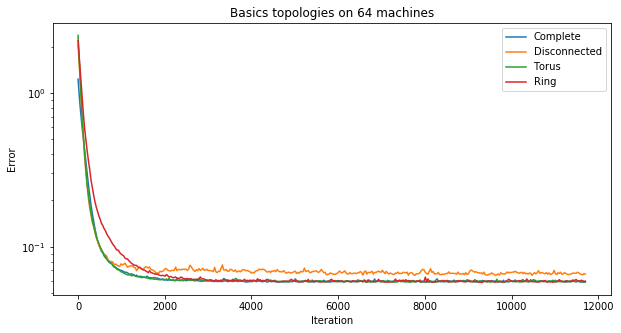

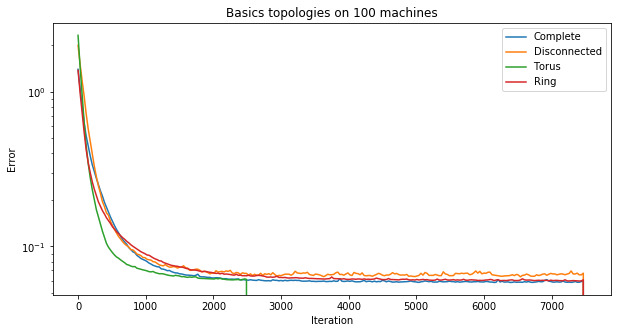

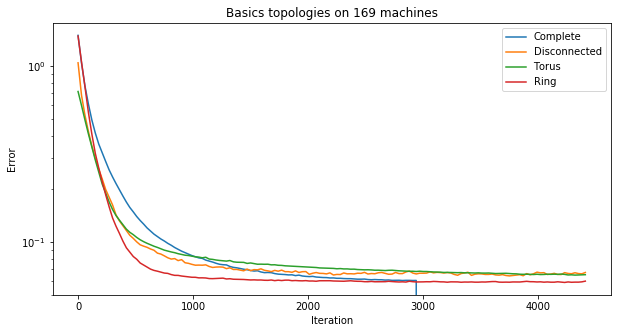

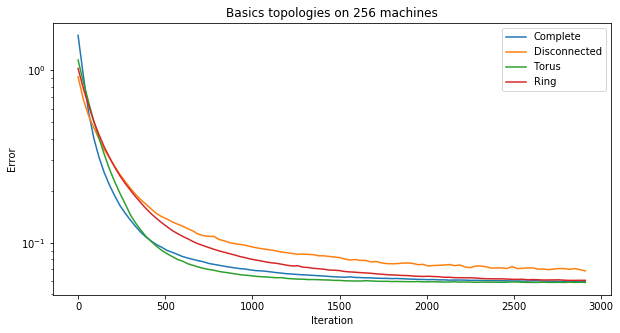

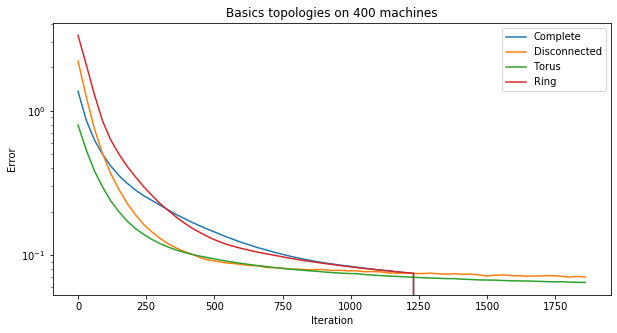

In [44]:
for i in range(len(n_machines)):
    iterations_indices = np.arange(0, losses_complete[i].shape[0] * compute_loss_every, 
                               compute_loss_every)
    plot_losses(np.stack((losses_complete[i], losses_disconnected[i], losses_torus[i], losses_ring[i])),
            iterations_indices, optimum_loss=optimum_loss, 
            labels=["Complete","Disconnected", "Torus", "Ring"], title="Basics topologies on {0} machines".format(n_machines[i]), save_as_pdf=True, pdf_name="Basics topologies on {0} machines".format(n_machines[i]))

### Barbell and Path topologies

In [10]:
params_barbell = params_disconnected.copy()
params_barbell['topology'] = 'barbell'
losses_barbell = run_logistic(A, y, params_barbell, logging=True)

length of indices: 512
length of last machine indices: 488
Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [488/488]      10s       0.5829    0.7111        
[2/5]      [488/488]      20s       0.5677    0.7196        
[3/5]      [488/488]      30s       0.5643    0.7233        
[4/5]      [488/488]      39s       0.5631    0.7249        

{'num_epoch': 5, 'lr_type': 'bottou', 'initial_lr': 0.1, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 512, 'method': 'plain', 'topology': 'barbell', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30} - score: 0.7249


In [11]:
params_path = params_disconnected.copy()
params_path['topology'] = 'path'
losses_path = run_logistic(A, y, params_path, logging=True)

length of indices: 512
length of last machine indices: 488
Epoch      Iteration      Time      Loss      Accuracy      
[1/5]      [488/488]      10s       0.5864    0.7235        
[2/5]      [488/488]      19s       0.5716    0.7271        
[3/5]      [488/488]      29s       0.5670    0.7297        
[4/5]      [488/488]      39s       0.5648    0.7289        
[5/5]      [488/488]      48s       0.5637    0.7280        
{'num_epoch': 5, 'lr_type': 'bottou', 'initial_lr': 0.1, 'tau': 30, 'regularizer': 4e-06, 'quantization': 'full', 'n_machines': 512, 'method': 'plain', 'topology': 'path', 'estimate': 'final', 'split_data_random_seed': 2, 'distribute_data': True, 'split_data_strategy': 'naive', 'compute_loss_every': 30} - score: 0.7280


In [12]:
iterations_indices = np.arange(0, losses_complete.shape[0] * compute_loss_every, 
                               compute_loss_every)
plot_losses(np.stack((losses_complete, losses_barbell, losses_path)),
            iterations_indices, optimum_loss=optimum_loss, 
            labels=["Complete","Barbell", "Path"], title="Different topologies")

NameError: name 'optimum_loss' is not defined